# url: https://note.com/sasayaka360/n/n353d043ef907

今回はアンサンブル学習の一つである，XGBoostというアルゴリズムを紹介します．

XGBoostはKaggle等のコンペでも上位ランクの常連になっているアルゴリズムで，とても精度が高い強力なモデルを作ることができます．(こちらにXGBoostを使った上位ランクのリストがありますが，これでもまだ一部だと思うのですごいですね^^;)

一部理論面で理解が難しいところもあるXGBoostですが，かなりわかりやすく解説していくので，是非ついてきてください！コンペなどではよく使うアルゴリズムかと思いますが，是非理論と長所/短所を理解した上で使えるようになりましょう◎

※XGBoostの理論の数式展開は結構骨が折れるので，本講座はあくあまでも入門講座ということで本記事では理論の概要とPythonでの実装にとどめます．興味がある人は原論文を読んでみてください！

## XGBoostとは？
XGBoostは，eXtreme Gradient Boostingの略で，決定木の勾配ブースティングアルゴリズムです．

まずは，「決定木」「勾配」「ブースティング」の３つのキーワードに注目しましょう．

XGBoostはブースティングアルゴリズムをベースとします．ブースティングについては第30回で紹介した通りですが，モデルがうまく予測できなかったデータに重みをつけてまたモデルを学習させて・・・というのを繰り返して最後にそれぞれのモデルを使って最終的な予測をするアルゴリズムでしたね

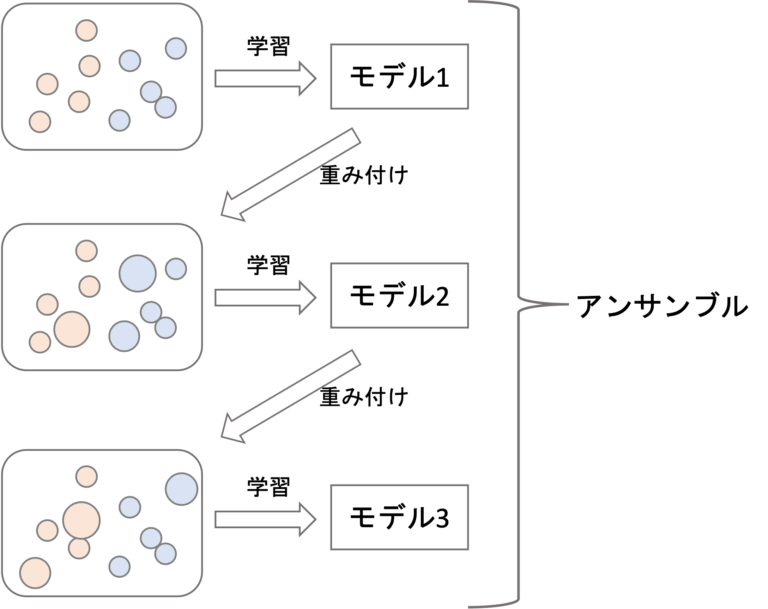

「勾配」は，第3回で触れたように，残差が少しでも小さくする方向のことで，XGBoostは残差を徐々に小さくするように学習を進めていきます．

なので，例えば上図のようにモデル1, モデル2, …とブースティングで直列にモデルを学習させるときに，モデル1→モデル2, モデル2→モデル3, …と残差が小さくなるように学習をしていきます．なので，普通のブースティングのように学習データの重づけをするのではなく，残差を計算して，それが小さくなるように次の決定木を学習することになります．

イメージとしては下図のようになります．

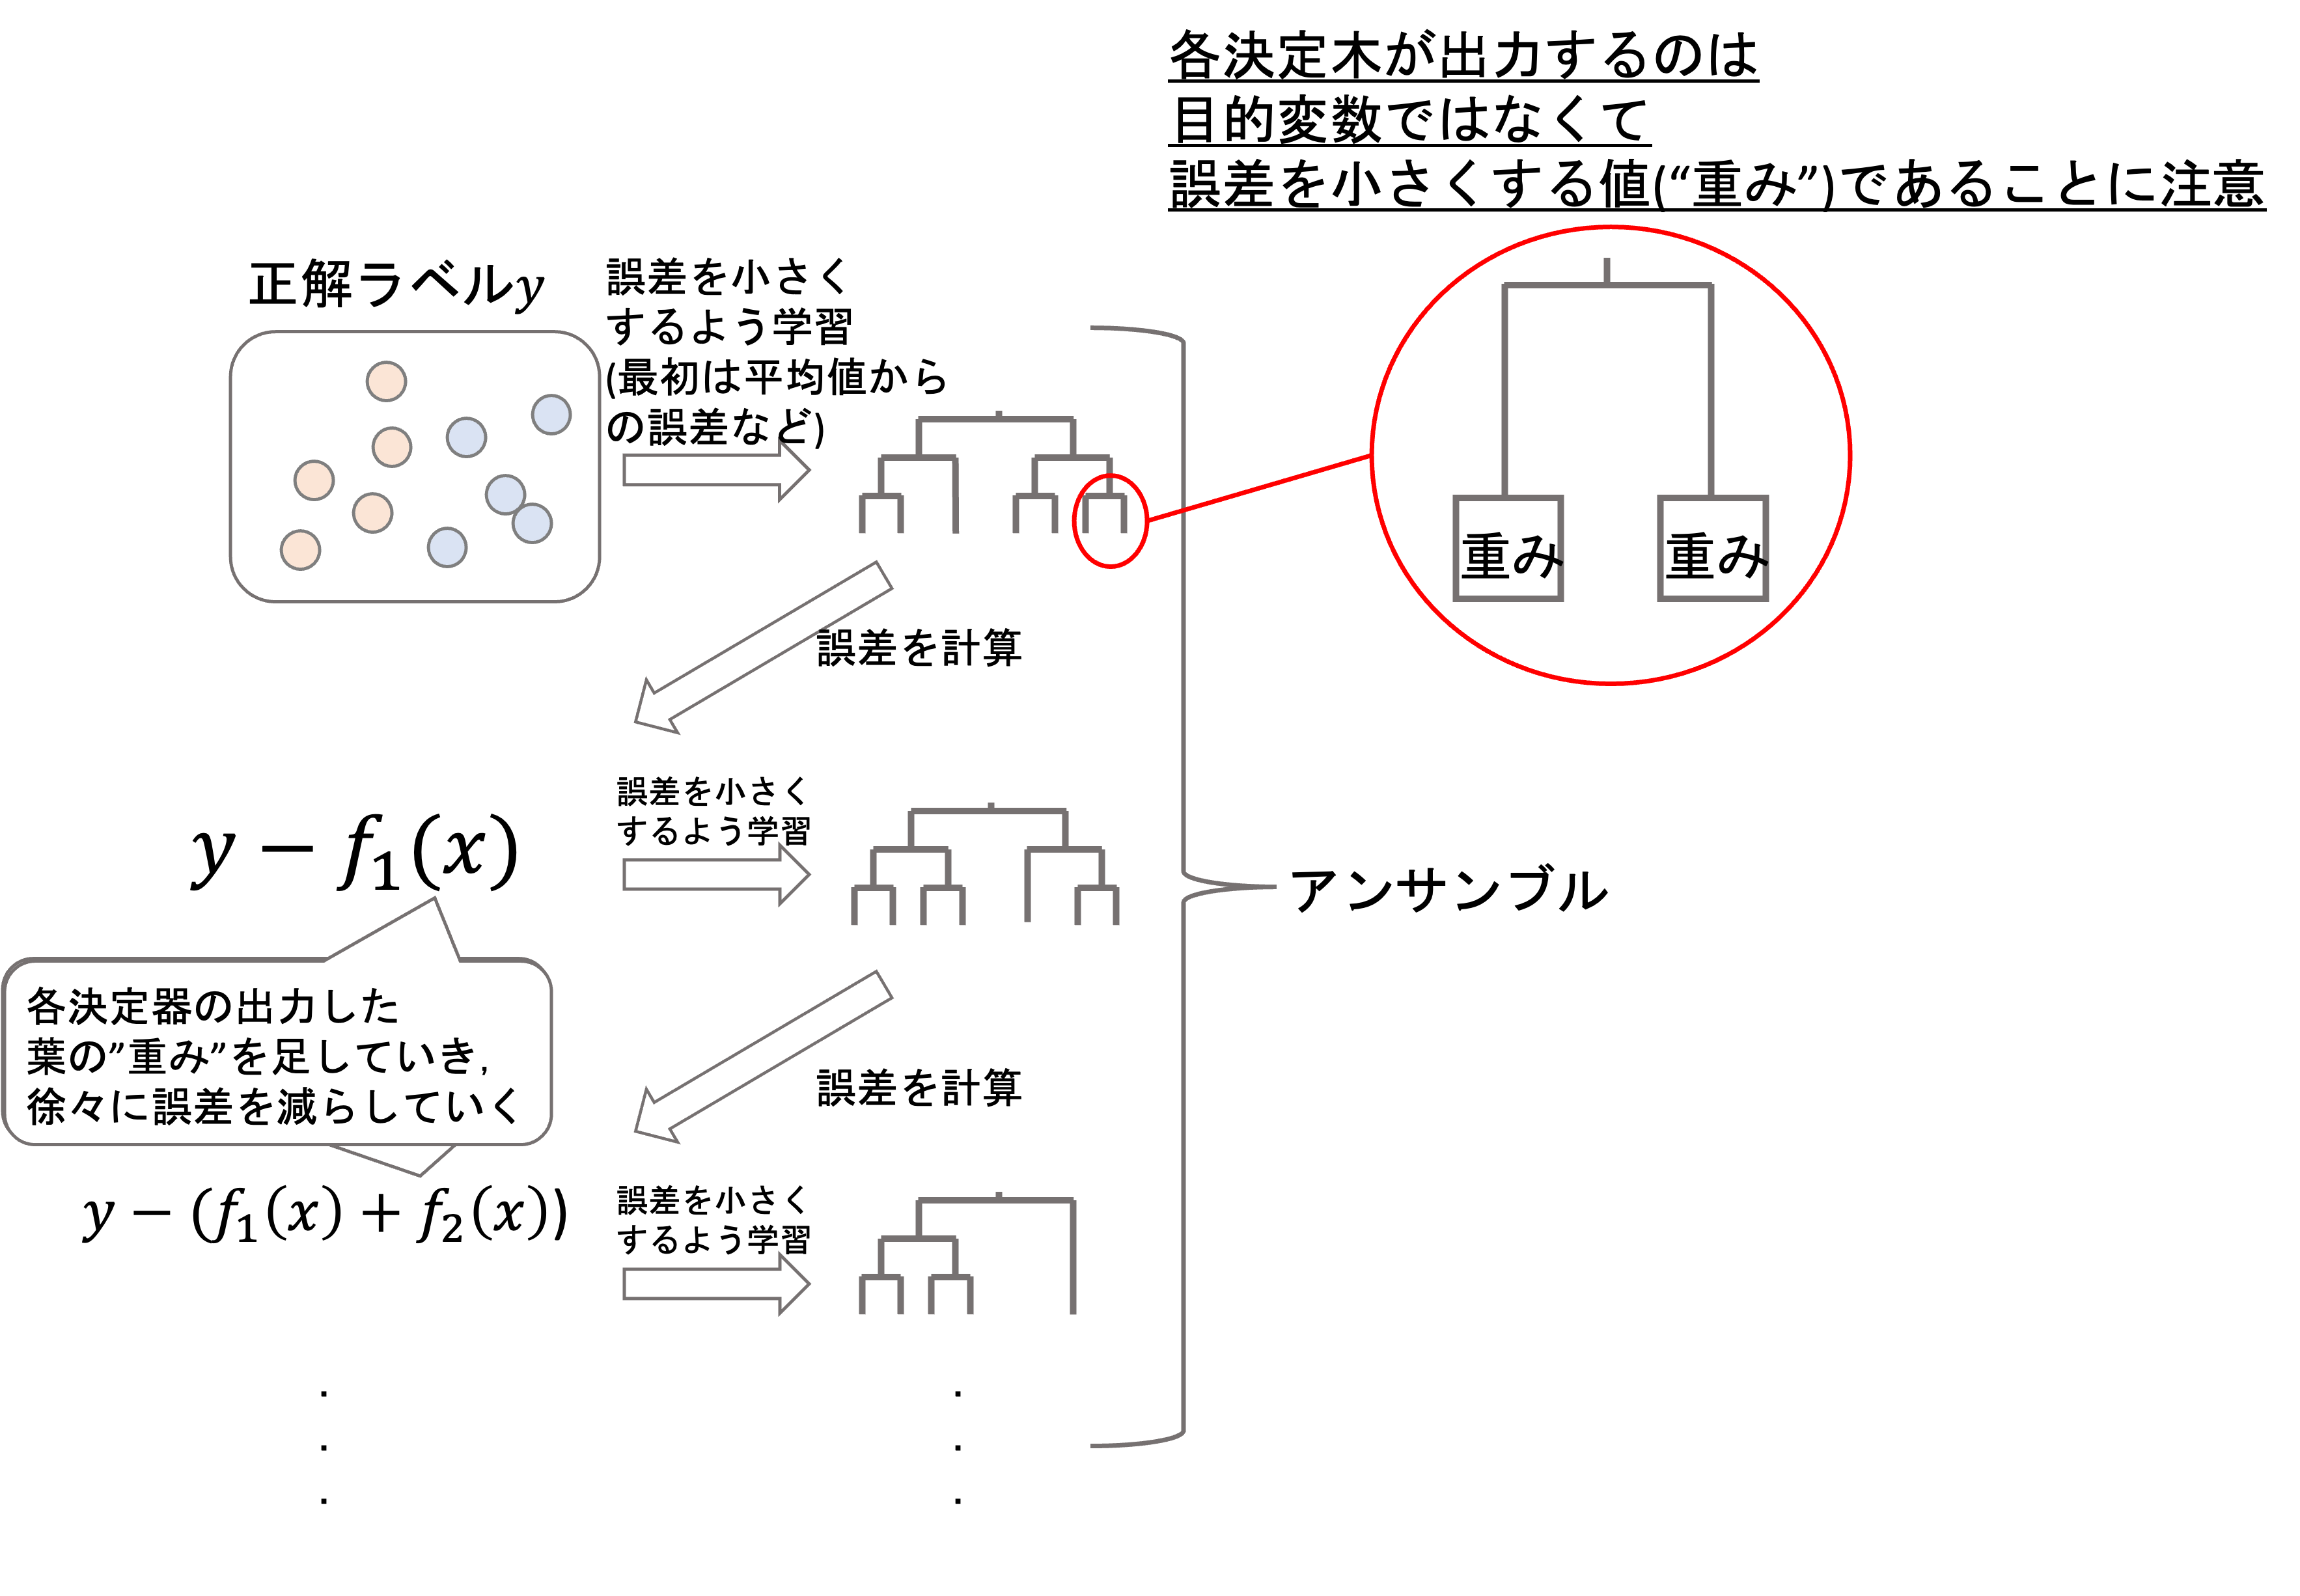

各決定木は，目的変数の値を出力するのではなく，ある値(これを葉の”重み”と呼びます)を出力するようにし，それを足し合わせて徐々に残差が減っていくようにするのです．(上図では，𝑡時点での決定木の出力結果を𝑓𝑡(𝑥))としています．ただし𝑥は学習データです．

つまり，最初のイテレーションでは一つ目の決定木の出力結果との残差𝑦−𝑓1(𝑥)を計算し，次のイテレーションではその残差を減らすための”重み”を学習します．(通常，最初の決定木の出力結果は平均値や，適当な値だと思っていただければいいです．つまりこの段階では残差はある程度大きいと思ってください)

二回目の決定木の学習で，残差を小さくするための値(=重み)を学習していきます．そして，次のイテレーションでは𝑦−(𝑓1(𝑥)+𝑓2(𝑥))を残差としてそれをまた小さくするための重みを次の決定木で学習していきます．

これを繰り返すことで残差を減らしていき，XGBoostでは最終的な予測の結果を∑𝐾𝑘=1𝑓𝑘(𝑥)とします．(実際には各決定木にある係数をかけます．これについては後述します．)

このようにが勾配(残差が小さくなる方向に)に沿ってモデルが学習されていくことから”Gradient”の名前がついています．

またこのように，XGBoostはモデルに決定木を使います．ランダムフォレストも，「バギング+決定木」で，モデルに決定木を使ってましたね．これはやはり，決定木はhigh varianceのモデルなのでアンサンブルによって効果がでやすいという点があります．

## XGBoostのアルゴリズム概要
XGBoostは以下の損失関数を小さくすることを目的として学習を進めていきます．

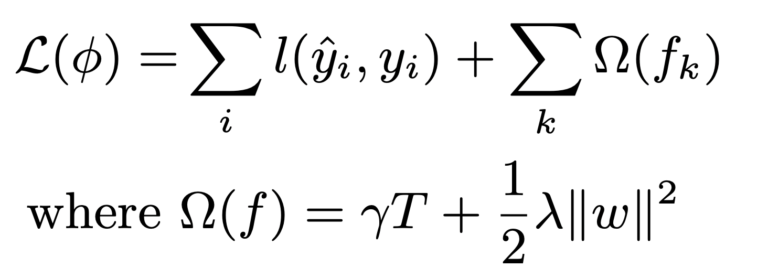

実はそんなに難しくないので，丁寧に解説するので頑張って理解しましょう！

まず，𝑙(𝑦̂ 𝑖,𝑦𝑖)は予測値𝑦̂ 𝑖と正解値𝑦𝑖の残差です．それを∑𝑖し，全てのデータの残差の総和を取ります．

そして∑𝑘Ω(𝑓𝑘)は正則化項の役割をします．正則化項については第14回で解説してます．要はペナルティを与える項ですね

どんなペナルティを与えるかというと，𝛾𝑇+12𝜆||𝜔||2というものです．

𝑇は決定木の葉の数，𝜔はその木の最終的に予測にした葉のスコア(つまりは決定木でいう予測値です．XGBoostでは重みと言います)です．

𝛾とか12𝜆とかの細かい係数は今回は気にしないでください．ただのハイパーパラメータです．

これを∑𝑘し，アンサンブルに使った全ての木の総和をとっています．

つまりは，XGBoostでは葉の数と各木の最終的な葉の重みにペナルティをかけ，木が複雑になり過ぎないようにしています．これはもちろん，過学習を避けるためですね！先のXGBoostの概要図において，最初のイテレーションでいきなり残差を埋めるための𝑓(𝑥)が大きかったら，残差がなくなってしまいイテレーションが早く終わってしまってモデル数も少なくなりアンサンブルとしての価値が無くなりますし，そんなすぐに残差がなくなったら，それは明らかに過学習してるといえるでしょう．

さて，先ほどの式にブースティングの要素を入れてみます．ブースティングは一つ前のモデルの結果を使って新たなモデルを学習することを繰り返すんでした．そして，XGBoostでは以前学習したモデルの結果を足し合わせて予測を出します．

つまり，𝑖番目のデータのある時点𝑡でのモデル(XGBoost)の予測結果𝑦̂ 𝑡𝑖は前の(モデル全体の)予測𝑦̂ (𝑡−1)𝑖とその時点での決定木の予測値𝑓𝑡(𝑥𝑖)の足し算になります．(実際にはこれに係数をつけていきますが，それについてはまた後述します)

つまり先ほどの式は以下のような漸化式で記述することができるわけです．

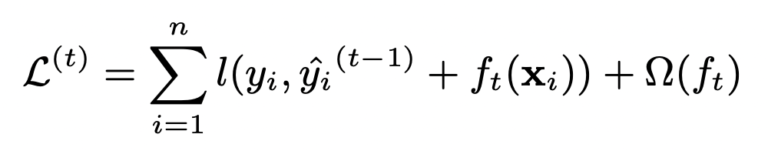

この式は𝑡時点での損失の式であることに注意しましょう．なので，正則化項の∑𝑘も外れ，その時点での決定木のものになってます

そしてこの損失が最小になる𝑓𝑡()と葉の重み𝜔を求めることになります．この求め方については数式の導出が長く，本講座で扱う範疇を超えるので割愛します．興味がある人は原論文を読んでみてください．

## 過学習を抑えるための工夫
XGBoostは，先ほどの正則化項以外にも色々と過学習を抑えるための工夫をしています

### Shrinkage(縮小)
それぞれの決定木の結果に係数𝜂(０〜1)をつけることで，それぞれの決定木の影響を小さく(縮小=shrinkage)します．

ある時点𝑡でのXGBoostの全体の予測値𝑦̂ 𝑡𝑖はそれ時点より一つ前(つまり一つ前のイテレーション)の予測値𝑦̂ (𝑡−1)𝑖にその時点で学習した決定木の結果𝑓𝑡(𝑥𝑖)を足したもの，つまり

𝑦̂ 𝑡𝑖=𝑦̂ (𝑡−1)𝑖+𝑓𝑡(𝑥𝑖)

でした．XGBoostでは残差を学習していくので，毎回の決定木𝑓𝑡(𝑥𝑖)は，その残差を小さくするためのものです．が，これをそのまま付け加えてしまうと，簡単に過学習してしまいます．(決定木が出力する値は，正解値との残差を埋める値です．そのまま採用してしまうと一気に残差がなくなってしまう恐れがあります．そうするとそこで学習は終わり，使用するモデル数も少なく過学習してしまうのです)

そのため，0<𝜂<1の係数を掛け，毎回の決定木の結果を縮小(shrinkage)させます．イメージとしては学習率(learning rate)に近い役割をします．つまり値が小さいとそれだけ残差のギャップを埋めるのに時間がかかり，学習が長引きます．

𝑦̂ 𝑡𝑖=𝑦̂ (𝑡−1)𝑖+𝜂𝑓𝑡(𝑥𝑖)
つまり，XGBoostの最終的な予測値は，全ての決定木の予測結果の総和ではなく，係数𝜂をつけた総和になります．

𝑦̂ 𝑖=∑𝑘=1𝐾𝜂𝑓𝑘(𝑥𝑖)
ただし𝐾はアンサンブルする決定木の数(=イテレーションの回数)です．

### 補足
ブースティングではXGBoostに限らず，このような学習率のようなshrinkageの係数をつけるのが一般的です
𝜂は小さければ小さい方がいいとも言われていますが，現実的な数字は0.3以下で，特に0.1以下がいいとされている印象です．が，これはお使いのマシンスペックに合わせて決めていただければ良いかと思います．

## Column Subsampling
これは前回の記事で解説したランダムフォレストで紹介したものと同じです．

一つ一つの決定木の分割に使う特徴量をランダムに選択します．(つまり，一部の特徴量のみ分割して決定木を作ります)

詳細は前回の記事に書いているので割愛しますが，XGBoostもランダムフォレスト同様にこの手法を採用し，過学習を防いでいます．

他にも，決定木の分割の近似アルゴリズムなどが原論文にありますが，本記事では割愛します．なお，本記事の数式はこちらの論文を参考にしております．



## PythonでXGBoostを使う
それでは，いつも通りPythonでXGBootを使うやり方を簡単に紹介します．

XGBoostをPythonで扱うには，まずXGBoostのパッケージをインストールする必要があります．(scikit-learnの中には実装されていないので注意してください．)

回帰モデルには xgboost.XGBRegressor を，分類モデルには xgboost.XGBClassifier を使います．どちらも仕様はほとんど同じです

今回は前回まで使っていたタイタニックのデータセットを使って，搭乗者が生存するかどうかの2値分類をする分類モデルを作ってみましょう．

## データ準備

In [1]:
import pandas as pd
import seaborn as sns

df = sns.load_dataset('titanic')
# df = df.dropna()
X = df.loc[:, (df.columns!='survived') & (df.columns!='alive')]
X = pd.get_dummies(X, drop_first=True)
y = df['survived']

今まで通りなので説明は省きますが，実はXGBoostは欠損値を対処するアルゴリズムが組み込まれているので，欠損値をdropしたり代入する必要がなく，欠損値があるデータをそのままモデルに学習させることができます．
これはXGBoostの特徴の一つです．詳細のアルゴリズムは原論文の3.4 Sparsity-aware Split Findingを参照ください．簡単にいうと，最初に欠損値がないデータが綺麗に分かれるように決定木の分割を行い，その後に欠損値データを右にするのか左にするのかをみて，スコア(例えばジニ不純度等)が最も良くなるように分割をします．

これを各ノードで試してくれるので，特徴量によって分割位置が異なり，これが欠損値代入と同じような処理をしてくれています．(以上の説明がわからなくてもあまり気にしなくてOK.アルゴリズムの詳細は本講座の範疇を超えているので．)

## 補足
もちろん，欠損値の代入処理をおこなってからXGBoostを学習させてもOKです．そちらの方が精度が高くなる場合もあるでしょう．ただ，代入してしまうと「欠損していた」という情報自体も失われてしまうので注意が必要です(その場合は「欠損値があった」というフラグをつけることもありますが，これについてはまた別記事で機会があったら紹介します・・・)．XGBoostを使う場合は欠損値対応はせずに，そのまま学習させる人が多い印象です．また，欠損値のデータをdropをしてしまうと学習データが減ってしまい一般的に精度が下がってしまいます．

今回は，このデータセットを学習データとテストデータを7:3に分けます．


In [2]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

## 学習
それでは学習データに対してXGBoostを学習させてみます．

基本的な使い方は他のscikit-learnの機械学習モデルのクラスと同じで， model=XGBClassifier() でインスタンスを生成して， model.fit(X_train, y_train) で学習をさせればOKです．

が，色々とパラメータをセットできるので，簡単によく使うものだけピックアップして解説します．

    XGBClassifier() のインスタンス生成時のパラメータは以下があります．
    n_estimators : ブースティングの回数(=学習する決定木の数)．デフォルトは100．
    learning_rate : shrinkageの𝜂．デフォルトは0.3なので少し高め．(低スペックマシンでの実行を想定しているのだと思われます．)
    max_depth : 決定木の最高の深さ．デフォルトは6
    eval_metric : ブースティング時の各イテレーション時に使う評価指標(特に後述するearly stoppingに使用). sklearn.metricsのメソッドを渡すか，自作してもOK．デフォルトは 'logloss'
    early_stopping_rounds : early stoppingする際の，最低限ブースティングのイテレーションをする回数

他にも色々とありますが，まずはこのあたりのパラメータを押さえておけばOKです．

early stoppingというのは，ブースティングのイテレーション時に評価指標がこれ以上下がらなくなったら自動で学習をやめてくれます．この仕組みにより， n_estimators や learning_rate のパラメータを探索する必要がほとんどなくなります． n_estimators には高い数字を， learning_rate には低い数字をセットしておけば，あとはearly stoppingで学習を回せば最も精度が高くなったところで自動で学習をやめてくれます．

## 補足
eval_metric や early_stopping_rounds は，1.6.0より古いバージョンでは .fit() 側のパラメータとなってます．
今回は以下のように設定し，early stoppingするようにしておきましょう．

In [3]:
from xgboost import XGBClassifier
model = XGBClassifier(early_stopping_rounds=10)

.fit()のよく使う引数は以下です．

    eval_set : (X, y)のリストで，これを渡すと，ブースティング時の各イテレーションごとにこのデータセットを使って評価してくれる．
    verbose : Trueにすると，各イテレーションでの評価指標などを表示し，イテレーションの軌跡を確認できる．

今回は，テストデータを各イテレーションで評価するデータとして使います．

In [4]:
eval_set = [(X_test, y_test)]
model.fit(X_train, y_train, eval_set=eval_set, verbose=True)

[0]	validation_0-logloss:0.53176
[1]	validation_0-logloss:0.46954
[2]	validation_0-logloss:0.43325
[3]	validation_0-logloss:0.41073
[4]	validation_0-logloss:0.39652
[5]	validation_0-logloss:0.38811
[6]	validation_0-logloss:0.38218
[7]	validation_0-logloss:0.37675
[8]	validation_0-logloss:0.37471
[9]	validation_0-logloss:0.37583
[10]	validation_0-logloss:0.37581
[11]	validation_0-logloss:0.37461
[12]	validation_0-logloss:0.37592
[13]	validation_0-logloss:0.37713
[14]	validation_0-logloss:0.37898
[15]	validation_0-logloss:0.38087
[16]	validation_0-logloss:0.37995
[17]	validation_0-logloss:0.37959
[18]	validation_0-logloss:0.38215
[19]	validation_0-logloss:0.38507
[20]	validation_0-logloss:0.38546
[21]	validation_0-logloss:0.38580


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

すると，このように各イテレーションでの評価指標を表示してくれます．

今回の場合は，[5]の時に最もloglossが低くなっており，そこからearly_stopping_rounds(=10回)以下にならなかったので，16回のイテレーションで終わっています．

これらは model.best_score と model.best_iteration で確認することができます．

また， .fit() はxgboostのモデルを返すので，そこも注意しておきましょう．( model 変数に格納しなくても， model 変数はすでに学習済みになっています．)

## 予測
他のsklearnの機械学習クラスと同様， .predict() や .predict_proba() で予測することができます． sklearn.metrics.log_loss で評価指標を計算して，イテレーション時の最小のloglossと一致することを確認しましょう．

In [5]:
from sklearn import metrics
y_pred = model.predict_proba(X_test)
metrics.log_loss(y_test, y_pred)

0.3746102413667132

## 補足
今回の例では，splitしたテストデータを検証データとして使ってearly stoppingをしましたが，この場合検証データに対して過学習となっていることに注意してください． 最終的なモデルとして相応しいかどうかは，kfoldCVで汎化性能を測って決めましょう．

## 特徴量の重要度
ランダムフォレスト同様，XGBoostも特徴量の重要度を出すことができます．( xgboost.plot_importance(model) でも同様なplotをしてくれる便利な関数が実装されています．)

<BarContainer object of 22 artists>

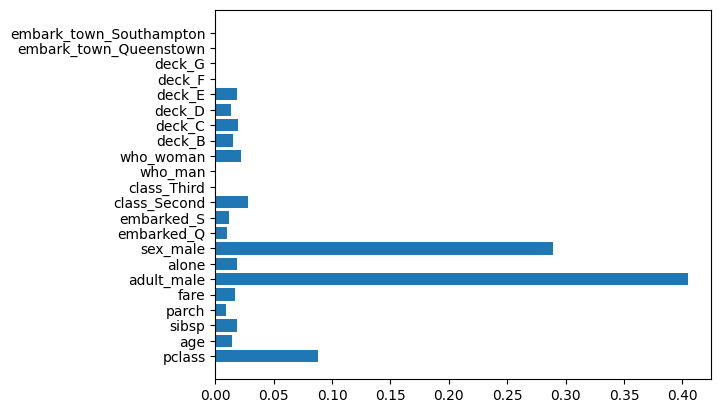

In [6]:
import matplotlib.pyplot as plt
model.feature_importances_
plt.barh(X.columns, model.feature_importances_)

まとめ
今回はXGBoostというアルゴリズムを紹介しました!

    XGBoostは非常に精度が高い強力な機械学習アルゴリズムである
    XGBoostは決定木の勾配ブースティングアルゴリズムである
    XGBoostは，ブースティング時に誤差が徐々に小さくなるように決定木を学習していく
    正則化項やshrinkage，column subsampling，early stoppingなどを行い，過学習を避けている
    XGBoostは欠損値の対処をアルゴリズムに組み込んでいるので，欠損値はそのまま学習アルゴリズムに使うことができる．
    XGBoostは，比較的新しいアルゴリズムで，登場以降多くのコンペの上位モデルで採用されてきました．

また，このXGBoostが世に出てからまもなく，また新たな「決定木の勾配ブースティングアルゴリズム」がでています．XGBoostを超える(!?)アルゴリズムとしてここ数年注目されているのがLightGBMと呼ばれるアルゴリズムです．

両者は似てるのですが，異なるアルゴリズムです．XGBoostがある程度わかれば，LightGBMも簡単に理解できるでしょう！

次回はそんなLightGBMについて解説をしていきます．さらに強力なアルゴリズムとも言えるので，是非このまま学習を進めていきましょう！